In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from Bio import SeqIO
import SearchTools

%matplotlib inline
sbn.set(font_scale=1.5)
sbn.set_style('white')


# Data Import

Sequence data is read in from the Los Alamos Database that is stored in the included `.tar.gz` file. These alignments were produced by the LANL tools and are aranged such that the HXB2 sequence is the last in the file. The alignment information is used to determine the HXB2 positions of each sequence. 

In [2]:
import tarfile
from collections import Counter
from copy import deepcopy
from itertools import compress
from collections import deque

def get_start_stop(seqR, hxb2_pos):
    """Determine the HXB2 start-stop of the sequence using affine-gaps."""
    
    it = zip(str(seqR.seq), hxb2_pos)
    poses = compress(it, (x[0] != '-' for x in it))
    start = poses.next()[1]
    stop = deque(poses, maxlen=1)[0][1]
    return start, stop


seq_locs = []

with tarfile.open('data/LANLdata.tar.gz', mode='r:gz') as tr:
    for f in tr:
        
        parts = f.name.split('/')[-1].split('.')[0].split('-')
        offset = int(parts[1])
        print 'Importing', f.name
        
        seqs = list(SeqIO.parse(tr.extractfile(f), 'fasta'))
        hxb2 = seqs[-1]

        hxb2_pos = []
        pos = offset-1
        for hx_l in str(hxb2.seq):
            pos += hx_l != '-'
            hxb2_pos.append(pos)

        for seqR in seqs[:-1]:
            if len(seqR.seq.ungap('-')) > 50:
                start, stop = get_start_stop(seqR, hxb2_pos)
                seq_locs.append({'sStart': start,
                                 'sStop': stop,
                                 'SeqR': deepcopy(seqR),
                                 'Name': seqR.id})

            
seq_df = pd.DataFrame(seq_locs)
print 'Total sequences imported', len(seq_locs)
seq_df.head()



Importing hiv-2500-3000.fixed.fst
Importing hiv-1100-1950.fixed.fst
Importing hiv-8300-8900.fixed.fst
Importing hiv-7100-7500.fixed.fst
Importing hiv-5200-5600.fixed.fst
Importing hiv-1-700.fixed.fst
Importing hiv-8500-8800.fixed.fst
Importing hiv-6200-6900.fixed.fst
Importing hiv-700-1150.fixed.fst
Importing hiv-2000-2500.fixed.fst
Importing hiv-5700-6100.fixed.fst
Importing hiv-9086-9717.fixed.fst
Importing hiv-4100-4900.fixed.fst
Importing hiv-3000-3500.fixed.fst
Importing hiv-7500-7900.fixed.fst
Importing hiv-3200-3500.fixed.fst
Total sequences imported 390290


,Name,SeqR,sStart,sStop
0,B.US.1997.ARES2.AB078005,"(A, C, A, T, A, A, T, T, G, -, -, -, -, -, G, ...",2500,3000
1,B.US.1985.Ba_L.AB221005,"(A, C, A, T, A, A, T, T, G, -, -, -, -, -, G, ...",2500,3000
2,B.US.1985.Ba_L.AB253432,"(A, C, A, T, A, A, T, T, G, -, -, -, -, -, G, ...",2500,3000
3,B.US.1991.US2.AB485638,"(A, C, A, T, A, A, T, T, G, -, -, -, -, -, G, ...",2500,3000
4,B.US.1991.US2.AB485639,"(A, C, A, T, A, A, T, T, G, -, -, -, -, -, G, ...",2500,3000


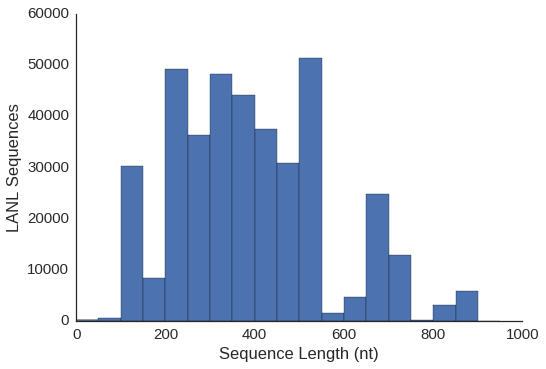

In [15]:
fig, ax = plt.subplots(1,1)
(seq_df['sStart']-seq_df['sStop']).abs().plot(kind='hist', 
                                              bins = np.arange(0, 1000, 50),
                                              ax=ax)
ax.set_xlabel('Sequence Length (nt)')
ax.set_ylabel('LANL Sequences')
sbn.despine(ax=ax)

__Figure__: LANL Sequences range from 150 nt in length to about 1000 nt with an average of 391 nt. Sequences were binned into a histogram of 50 nt bins.

In [4]:
ex_df = pd.read_excel('data/gRNAList.xlsx')
ex_df['gRNA'] = ex_df['gRNA'].str.strip()
ex_df.head()

,Citation,Name,Start,Stop,gRNA,Region
0,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,LTR
1,23974631,T6,343,362,GCTACAAGGGACTTTCCGCT.NGG,LTR
2,25049410,LTR-A,98,127,AGGGCCAGGGATCAGATATCCACTGACCTT.NGG,LTR
3,25049410,LTR-B,312,341,CCN.GAGTACTTCAAGAACTGCTGACATCGAGCT,LTR
4,25049410,LTR-C,78,97,GATTGGCAGAACTACACACC.NGG,LTR


# Sequence Processing

Now that the gRNAs and sequences have been loaded we'll compare them. Each gRNA will be parsed to extract the protospacer region. For each gRNA we extract all sequences that overlap the target region. Then, the MIT penalty matrix is applied exauhstively across the entire sequence to determine the ideal binding location.

In [5]:
from Bio.Seq import reverse_complement


In [6]:
def parse_grna(gRNA):
    """Extract and normalize the length of the protospacer"""
    
    parts = gRNA.split('.')
    if len(parts[1]) == 3:
        direc = 'Forward'
        proto = parts[0][-20:]
    else:
        direc = 'Reverse'
        proto = parts[1][:20]
        
    if len(proto) < 20:
        proto = 'N'*(20-len(proto)) + proto
        
    return direc, proto


def check_whole_seq(seq, gRNA):
    """Apply the MIT penalty matrix across every postion on the sequence."""
    
    direc, query = parse_grna(gRNA)
    
    # Normalize the orientation and ungap the sequence
    if direc == 'Reverse':
        nseq = seq.ungap('-')[::-1]
        query = query[::-1]
    else:
        nseq = seq.ungap('-')
    
    # Check every 20-mer in the sequence.
    scores = []
    for start in range(len(nseq)-20):
        scores.append(SearchTools.gRNA_score_hit(query, nseq[start:start+20]))

    # Find the best score
    scores = pd.Series(scores)
    bscore, bloc = scores.max(), scores.idxmax()
    
    # Prep outputs
    oseq = str(nseq[bloc:bloc+23])
    has_pam = oseq.endswith('GG')
    if direc == 'Reverse':
        oseq = oseq.encode('ascii')[::-1]
        has_pam = oseq.startswith('CC')
    
    return oseq, bscore, direc, has_pam
    

In [7]:
num = 0
scores = []

# Run through each gRNA
for _, row in ex_df.iterrows():
    
    # Extract all sequences that overlap the target region
    mask = (seq_df['sStart'] < (row['Start']-20)) & (seq_df['sStop'] > (row['Stop']+20))
    
    for _, seq_row in seq_df.ix[mask].iterrows():
        num += 1
        if num % 50000 == 0:
            print num, row['Name'], row['Start']
        
        # Check this sequence for the presence of this gRNA
        hit, score, direc, has_pam = check_whole_seq(seq_row['SeqR'].seq, row['gRNA'])
    
        # Extract some information
        scores.append({'Hit': str(hit),
                       'Score': score,
                       'gRNA': row['gRNA'],
                       'Citation': row['Citation'],
                       'Direc': direc,
                       'SeqID': seq_row['Name'],
                       'gStart': row['Start'],
                       'gStop': row['Stop'],
                       'HasPam': has_pam,
                       'Name': row['Name'].strip(),
                       'Region': row['Region']})

score_df = pd.DataFrame(scores)
# Since the PAM is required, any sequence without a PAM will have its value zeroed out
score_df['ProtoPam'] = score_df['Score']*(score_df['HasPam'].astype(float))

# We need to exclude sequences which have Ns in the target region
score_df['HasN'] = score_df['Hit'].str.contains('N')
score_df.head()   

50000 gEnv-T3 7343
100000 gP24-T1  1254
150000 gPol-T1 2374
200000 gRev-T1 8378
250000 gRev-T2 8568
300000 T10  8532
350000 T4  2255
400000 T5 2805
450000 T9 8406
500000 sg362F.v4 355
550000 gEnv1 7216
600000 gGag2 1909
650000 gPol1 2571
700000 gPol2 3346
750000 Gag-A 1465
800000 LTR-S 213
850000 EnvV2 6793
900000 EnvV4 7431
950000 T10 sgRNA 8513
1000000 gRNA Gag D 1061
1050000 CA3 1617
1100000 RT1 2861
1150000 gRNA-RRE 7782
1200000 gGag1 1389
1250000 gPol3 4149
1300000 MA3  815
1350000 PR1  2374
1400000 PR2  2463
1450000 PR3  2310
1500000 PR4  2303
1550000 PR5  2312
1600000 RT2  2662
1650000 RT3  2706
1700000 RT4  2805
1750000 LTR-1 83


,Citation,Direc,HasPam,Hit,Name,Region,Score,SeqID,gRNA,gStart,gStop,ProtoPam,HasN
0,23974631,Forward,True,GTTAGACCAGATCTGAGCCTGGG,T5,LTR,1.000,A0001-R01-PBMC-Genomic-LTR,GTTAGACCAGATCTGAGCCT.NGG,465,484,1.000,False
1,23974631,Forward,True,GTTAGACCAGATCTGAGCCTGGG,T5,LTR,1.000,A0001-R04-PBMC-Genomic-LTR,GTTAGACCAGATCTGAGCCT.NGG,465,484,1.000,False
2,23974631,Forward,True,GTTAGACCAGATTTGAGCCTGGG,T5,LTR,0.387,A0002-R01-PBMC-Genomic-LTR,GTTAGACCAGATCTGAGCCT.NGG,465,484,0.387,False
3,23974631,Forward,True,GTTAGACCAGATTTGAGCCTGGG,T5,LTR,0.387,A0002-R03-PBMC-Genomic-LTR,GTTAGACCAGATCTGAGCCT.NGG,465,484,0.387,False
4,23974631,Forward,True,GTTAGACCAGATCTGAGCCTGGG,T5,LTR,1.000,A0002-R04-PBMC-Genomic-LTR,GTTAGACCAGATCTGAGCCT.NGG,465,484,1.000,False


In [8]:
from scipy.stats import entropy

def calc_entropy(ser):    
    return entropy(ser.value_counts()/len(ser), base=2)


# Group by each gRNA and calculate the entropy of the hits

entropies = score_df.groupby('gRNA')['Hit'].agg(calc_entropy)

In [9]:

cuts = np.arange(0, 1.05, 0.05)

sum_data = []
# Group by gRNA and Cititation and calculate aggregate stats
for (grna, cit), rows in score_df.query('HasN == False').groupby(['gRNA', 'Citation']):
    
    rows = rows.groupby('SeqID', as_index=False).first()
    
    has_pam = rows['HasPam'].mean() # Fraction of hits with adjacent PAMs
    num_seqs = len(rows)
    
    for cut in cuts:
        proto_mean = rows['Score'].mean() # Average MIT score
        proto_cut = (rows['Score']>cut).mean() # Fraction of sequences with MIT > cutoff

        proto_pam_mean = rows['ProtoPam'].mean() # Average MIT score with missing PAMs counting as Zero
        proto_pam_cut = (rows['ProtoPam']>cut).mean() # Fraction of sequences with MIT > cut and missing PAMs counting as Zero

        # Collect aggregate data
        sum_data.append({'gRNA': grna,
                         'Cutoff': cut,
                         'Citation': cit,
                         'HasPam': has_pam,
                         'NumSeqs': num_seqs,
                         'ProtoMean': proto_mean,
                         'ProtoCut': proto_cut,
                         'ProtoPamMean': proto_pam_mean,
                         'ProtoPamCut': proto_pam_cut,
                         'Start': rows['gStart'].iloc[0],
                         'Stop': rows['gStop'].iloc[0],
                         'Name': rows['Name'].iloc[0],
                         'Entropy': entropies[grna],
                         'Region': rows['Region'].iloc[0]})
    
order = ['Region', u'Citation', u'Name', u'Start', u'Stop', u'gRNA', 'Cutoff',
         u'ProtoMean', 'ProtoCut', 
         u'HasPam',  u'ProtoPamMean', 'ProtoPamCut', 'Entropy', u'NumSeqs']
sum_df = pd.DataFrame(sum_data)[order].sort_values(by = ['Citation', 'Name']).reset_index(drop=True)
sum_df.head()

,Region,Citation,Name,Start,Stop,gRNA,Cutoff,ProtoMean,ProtoCut,HasPam,ProtoPamMean,ProtoPamCut,Entropy,NumSeqs
0,LTR,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,0.00,0.77627,1.000000,0.963828,0.769499,0.963828,2.615312,1327
1,LTR,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,0.05,0.77627,0.978146,0.963828,0.769499,0.963075,2.615312,1327
2,LTR,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,0.10,0.77627,0.963828,0.963828,0.769499,0.951771,2.615312,1327
3,LTR,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,0.15,0.77627,0.876413,0.963828,0.769499,0.870384,2.615312,1327
4,LTR,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,0.20,0.77627,0.874906,0.963828,0.769499,0.868877,2.615312,1327


# Results

In [10]:
# Output raw results to Excel sheet for later processing

sum_df.to_excel('results/summary_res_all_gRNAs.xlsx', index=False)

In [11]:
from collections import defaultdict
import os

def pathify(citation, name, base_dir = 'results/FrequencyTables/'):
    
    fname = '%i_%s.xlsx' % (citation, name.strip())
    return os.path.join(base_dir, fname.replace(' ', '-'))
    
# Extract the nucleotide frequencies for all gRNAs

for (cit, name), df in score_df.groupby(['Citation', 'Name']):

    counts = defaultdict(float)
    tot = 0
    for n in df.query('HasN == False')['Hit'].str.upper().values:
        tot += 1
        for p, l in enumerate(n):
            counts[(p, l)] += 1

    order = 'ACGT'
    d = []
    for num in range(23):
        d.append([counts[(num, l)] for l in order])

    res = pd.DataFrame(d, columns = list(order), index=range(1, 24)).T/tot
    res.to_excel(pathify(cit, name))
